# Redes Neuronales
## Preparacion de datos para el modelo

In [8]:
import sys
sys.path.append('../')

import Utilidades as ut
import Modelos as md
import numpy as np
import pandas as pd


df_train = pd.read_pickle("../Archivos/Neuronales_entrenamiento.pkl")
df_test = pd.read_pickle("../Archivos/Neuronales_validacion.pkl")

if ('Opportunity_ID' in df_test):
    df_test = df_test.drop(columns=['Opportunity_ID'])

####MOMENTANEO

#df_train = df_train.drop(columns=['Opportunity_Created_Date'])
#df_test = df_test.drop(columns=['Opportunity_Created_Date'])

##############3
    
x_train, y_train = ut.split_labels(df_train)
x_test, y_test = ut.split_labels(df_test)

#Convertimos las fechas a numeros (cantidad de dias transcurridos) y luego las normalizamos
x_train, x_test = ut.conversion_fechas(x_train, x_test)
x_train, x_test = ut.codificar_categoricas(x_train, y_train, x_test, modo='catboost')
x_train, x_test = ut.normalizacion_numericas(x_train, x_test, modo='normalizacion')
x_train.shape

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


(12140, 21)

## Creacion del modelo.

In [9]:
import keras
import tensorflow as tf
from keras import backend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2
from sklearn.metrics import accuracy_score, log_loss


x_train_vector = ut.df_a_vector(x_train)
y_train_vector = ut.df_a_vector(y_train)
x_test_vector = ut.df_a_vector(x_test)
y_test_vector = ut.df_a_vector(y_test)

best_hparams = ut.hyperparams_from_json('../Archivos/Neuronales')
model = md.get_neural_network_model(best_hparams, x_train.shape[1])

epochs = 250
batch_size = 256


my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Neuronales_Mejor_Modelo.hdf5", 
                                       monitor='val_loss', 
                                       verbose=0,
                                       save_best_only=True, 
                                       mode='min'),
    
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                     min_delta=0.0001,
                                     mode='min',
                                     patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                      mode='min',
                                      factor=0.5,
                                      min_delta=0.0001,
                                      patience=2,
                                      cooldown=0, 
                                      min_lr=1e-24)
]

last_best = 0.200

tot = 1

for a in range(1, tot+1):
    print(f"Iteracion numero {a} de {tot}")
    model = md.get_neural_network_model(best_hparams, x_train.shape[1])
    #backend.set_value(model.optimizer.learning_rate, 1e-4)
    history = model.fit(x_train_vector,
                        y_train_vector,
                        validation_data=(x_test_vector, y_test_vector),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=my_callbacks)
    new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
    y_pred_proba = new_model.predict(x_test_vector).flatten()
    score = log_loss(y_test_vector.flatten(), y_pred_proba, eps=1e-7)
    if score < last_best:
        print(f"Se ha conseguido un score mejor al anterior. log_loss = {score}")
        score_redondeado = round(score, 4)
        print("Guardando modelo en: 'Mejores_Modelos/Neuronales_logloss_" + str(score_redondeado) + "_10_features.hdf5")
        new_model.save('Mejores_Modelos/Neuronales_logloss_' + str(score_redondeado) + '_10_features.hdf5')
        print(f"Best log_loss = {score}")
        last_best = score
#
#history = model.fit(x_train_vector,
#                       y_train_vector,
#                       validation_data=(x_test_vector, y_test_vector),
#                       epochs=epochs,
#                       batch_size=batch_size,
#                       verbose=1,
#                       callbacks=my_callbacks)

Cargando hiperparametros desde el archivo: '../Archivos/Neuronales_best_hyperparam.json'
Iteracion numero 1 de 1


## Resultados

In [10]:
new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_model = keras.models.load_model('Neuronales_logloss_1937_5_features.hdf5')
#new_model.save('Neuronales_logloss_1937_5_features.hdf5')
#new_model = keras.models.load_model('Neuronales_Mejor_Modelo.hdf5')
#new_predictions = new_model.predict(x_test)

In [11]:
from sklearn.metrics import accuracy_score, log_loss

y_pred_proba = new_model.predict(x_test_vector).flatten()
y_pred = [a > 0.5 for a in y_pred_proba]


acc = accuracy_score(y_pred, y_test_vector)
loss = log_loss(y_test_vector.flatten(), y_pred_proba, eps=1e-7)
print(f"acc: {acc}")
print(f"log_loss: {loss}")

acc: 0.7102990033222591
log_loss: 0.5528050795032469


In [12]:
#Probamos normalizar al intervalo (0, 1)
vector = y_pred_proba.flatten()

min_ = vector.min()
max_ = vector.max()
div = max_ - min_

for i, a in enumerate(vector):
    vector[i] = (a - min_) / div

    
score = log_loss(y_test_vector.flatten(), vector, eps=1e-7)
score

0.5382515021357329

In [13]:
new_model.evaluate(x_test_vector, y_test_vector)#, metrics=['accuracy'])

142/142 [==============================] - 0s 2ms/step - loss: 0.6234


0.6233997344970703

In [14]:
#Podemos analizar las filas que originaron los errores de prediccion

analysis_df = y_test.copy()
analysis_df['Predicted'] = pd.Series(y_pred).astype(int)
differences = (analysis_df['Predicted'] != analysis_df['Stage'])
df_test[differences]

,Opportunity_Name_Planned_Opportunity_Duration_median,Opportunity_Name_Planned_Opportunity_Duration_max,Product_Name_Planned_Time_Until_Deliver_mean,Opportunity_Name_Planned_Time_Until_Deliver_median,Product_Name_Planned_Opportunity_Duration_median,Planned_Time_Until_Deliver,Opportunity_Name_Planned_Time_Until_Deliver_min,Opportunity_Name_Planned_Time_Until_Deliver_max,Account_Name_Planned_Opportunity_Duration_mean,Account_Name_Planned_Time_Until_Deliver_median,...,Account_Name_Product_Amount_Deviation_of_Product_Family_rate_mean,Product_Name_Planned_Opportunity_Duration_std,Product_Name_Planned_Deliver_Duration_mean,Opportunity_Name_Total_Amount(USD)_median,Opportunity_Name_Product_Amount_Deviation_of_Product_Family_rate_min,Product_Name_Bureaucratic_Code_0_Approval_mean,Bureaucratic_Code_Opportunity_Duration_Ratio_mean,Product_Name_Product_Amount_Deviation_of_Product_Family_rate_median,Opportunity_Created_Date,Stage
1,143.0,143.0,93.967213,104.0,80.0,104.0,104.0,104.0,106.056537,41.0,...,0.023280,115.008348,19.885246,5.497758,0.113619,0.483607,412.684314,0.110919,2018-01-02,1
3,124.0,124.0,103.395280,118.0,94.0,118.0,118.0,118.0,179.636364,118.0,...,0.069626,99.761826,14.457227,3.921230,0.034997,0.442478,412.684314,0.000000,2018-01-03,1
5,65.0,65.0,103.395280,57.0,94.0,57.0,57.0,57.0,179.636364,118.0,...,0.069626,99.761826,14.457227,3.618805,-0.098309,0.442478,412.684314,0.000000,2018-01-03,1
10,124.0,124.0,146.858268,118.0,143.0,118.0,118.0,118.0,179.636364,118.0,...,0.069626,124.984336,18.440945,3.921230,0.034997,0.645669,412.684314,0.053533,2018-01-03,1
23,28.0,28.0,15.000000,12.0,29.0,12.0,12.0,12.0,28.520000,7.0,...,-0.178677,11.824108,13.142857,4.280601,-0.071512,0.857143,412.684314,0.000000,2018-01-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4480,10.0,10.0,64.784661,7.0,66.0,7.0,7.0,7.0,10.000000,7.0,...,0.053220,71.017254,16.755162,3.372169,-0.266891,0.542773,67.404882,-0.015052,2018-12-17,1
4483,10.0,10.0,103.395280,7.0,94.0,7.0,7.0,7.0,10.000000,7.0,...,0.053220,99.761826,14.457227,3.372169,-0.266891,0.442478,67.404882,0.000000,2018-12-17,1
4487,44.0,44.0,79.977528,15.0,63.5,15.0,15.0,15.0,79.933333,20.0,...,0.116006,78.894565,15.550562,5.025363,0.009479,0.522472,412.684314,-0.017095,2018-12-18,0
4500,29.0,29.0,164.140000,18.0,143.5,18.0,18.0,18.0,134.800000,18.0,...,0.121375,138.476284,22.200000,5.328807,0.087830,0.560000,412.684314,0.121389,2018-12-20,1


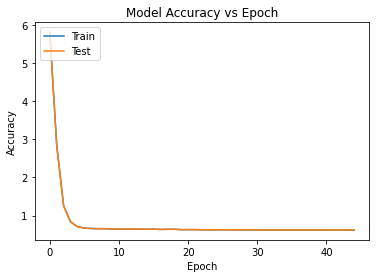

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()